In [2]:
import math
import numpy as np

from bloqade import rydberg_h, piecewise_linear, piecewise_constant, waveform, cast
from bloqade.atom_arrangement import ListOfLocations, Lieb, Square, Chain, Honeycomb, Kagome, Triangular, Rectangular
from bokeh.io import output_notebook # to plot "show()" on the notebook, without opening a browser
import os
import matplotlib.pyplot as plt

import pickle
import time

from scipy.signal import convolve2d
from pathlib import Path
import os
import re
from mpl_toolkits.mplot3d import Axes3D
from scipy.special import erf

output_notebook()

Loading BokehJS ...

In [3]:
unit_disc_grid_2_1 = {"lattice_dimension": [2, 2],"occupied_nodes": [1,2,3, 4], "unit_disc_radius": 1}
unit_disc_grid_2_sqrt2 = {"lattice_dimension": [2, 2],"occupied_nodes": [1,2,3, 4], "unit_disc_radius": np.sqrt(2)}

unit_disc_grid_3_1 = {"lattice_dimension": [3, 3],"occupied_nodes": [1,2,3, 4, 5, 6, 7, 8, 9], "unit_disc_radius": 1}
unit_disc_grid_3_sqrt2 = {"lattice_dimension": [3, 3],"occupied_nodes": [1,2,3, 4, 5, 6, 7, 8, 9], "unit_disc_radius": np.sqrt(2)}
unit_disc_grid_3_2 = {"lattice_dimension": [3, 3],"occupied_nodes": [1,2,3, 4, 5, 6, 7, 8, 9],"unit_disc_radius": 2}

unit_disc_grid_5_2 = {"lattice_dimension": [4, 5],"occupied_nodes": list(range(20)),"unit_disc_radius": 2}

unit_disc_grid_4x5_2sqrt2 = {"lattice_dimension": [4, 5],"occupied_nodes": [1,2,3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,16, 17, 18, 19, 20],"unit_disc_radius": 2*np.sqrt(2)}

unit_disc_grid_4_sqrt2 = {"lattice_dimension": [4, 4],"occupied_nodes": [1,2,3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,16],"unit_disc_radius": np.sqrt(2)}     

unit_disc_grid_3x5_sqrt5 = {"lattice_dimension": [3, 5],"occupied_nodes": [1,2,3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],"unit_disc_radius": np.sqrt(5)}


0.0
0.1111111111111111
0.2222222222222222
0.3333333333333333
0.4444444444444444
0.5555555555555556
0.6666666666666666
0.7777777777777777
0.8888888888888888
1.0


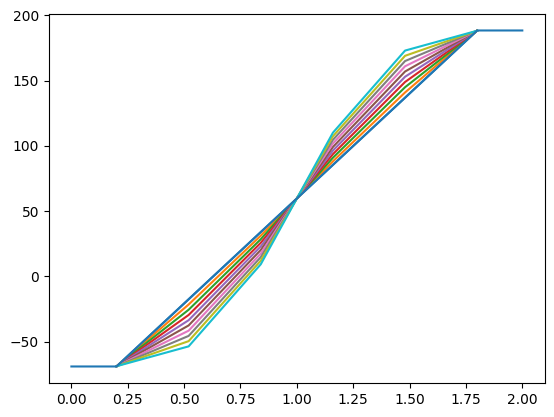

In [4]:
def error(x, min_val, max_val, w):
    return (0.5*erf((x-1)*w*1.4)*1.01+0.5) * (max_val - min_val) + min_val

d_end = 30 * np.pi * 2
d_start = -11*2*np.pi

n = 6
pivots = np.linspace(0.2, 1.8, n)
values = np.linspace(d_start, d_end, n)

x = np.linspace(0.2, 1.8, n)
y = error(x, d_start, d_end, 1.6)

for i in np.linspace(0, 1, 10).astype(float):
    print(i)
    plt.plot(x,values + i * (y-values))

pivots = [0] + list(pivots) + [2]
values = [d_start] + list(values) + [d_end]

plt.plot(pivots, values)

In [27]:
def error(x, min_val, max_val, w):
    return (0.5*erf((x-1)*w*1.4)*1.01+0.5) * (max_val - min_val) + min_val

def norm(x):
    return sum([ i**2 for i in x])

def upper_bound(r):
    L = [ (i,j) if norm((i,j)) > r**2 else [2*r,0] for i in range(math.ceil(r), math.ceil(r)+4) for j in range(i+1)]
    return min(map(lambda x: math.sqrt(norm(x)), L))


def lower_bound(r):
    L = [ (i,j) if norm((i,j))<= r**2 else [0,0] for i in range(math.floor(r)+2) for j in range(i+2) ]
    R  = max(map(lambda x: math.sqrt(norm(x)) , L))
    return R
    
def radius_interval(r):
    return [lower_bound(r), upper_bound(r)]


def circle_kernel(radius):
    kernel_size = int(np.floor(radius))*2+1
    kernel = np.zeros((kernel_size, kernel_size))
    
    for i in range(kernel_size):
        for j in range(kernel_size):
            if (radius)**2 >= (i-int(radius))**2+(j-int(radius))**2:
                kernel[i][j] = 1
    kernel[int(radius)][int(radius)] = 0
    return kernel


def is_independent(arr, kernel, radius, return_missed=True):
    kernel_sum = np.sum(kernel)
    padded = np.pad(arr, int(radius), constant_values=1)
    convolved = convolve2d(padded, kernel, mode="valid")

    is_independent = np.all(convolved[np.bitwise_not(arr.astype(bool))] == kernel_sum)

    if return_missed:
        return is_independent, ((convolved == kernel_sum) ^ arr).astype(bool)
    else: 
        return is_independent


def peform_sweep(unit_disc, opt_steps, save_name, show=True):
    os.makedirs(save_name, exist_ok=True)

    index = 1
    location_list = []
    for x in range(unit_disc["lattice_dimension"][0]):
        for y in range(unit_disc["lattice_dimension"][1]):
            if index in unit_disc["occupied_nodes"]:
                location_list.append((x*4, y*4))
            index = index + 1
    
    atom_coordinate = ListOfLocations(location_list)
        
    #dynamics
    durations = [0.2,1.6,0.2]
    r_min, r_max = radius_interval(unit_disc["unit_disc_radius"])
    d_end = 30 * np.pi * 2 # 0.15
    d_start = -11*2*np.pi
    Om_max =  2.5 # d_end/1.5
    print(r_min)
    print(d_start)
    print(r_max)
    print(d_end)

    n = 8
    pivots = [1.6/n for _ in range(n)]
    pivots = [0.2] + list(pivots)
    values = np.linspace(d_start, d_end, n)

    x = np.linspace(0.2, 1.8, n)
    y = error(x, d_start, d_end, 1.6)
    outputs = []

    for i in np.linspace(0, 1, 10).astype(float):
        vals = values + i * (y-values)
        vals = [d_start] + list(vals) + [d_end]

        # print([d_start] + list(vals) + [d_end])
        # print(pivots)
        Delta = piecewise_linear(list(pivots) , vals)
        Omega = piecewise_linear([0.2,1.6,0.2], [x*2*np.pi for x in [0,Om_max, Om_max,0]])

        program = rydberg_h(atom_coordinate, detuning=Delta, amplitude=Omega, phase=None)

        program.parse_register()
        program.parse_sequence()

        output = program.bloqade.python().run(shots=100, interaction_picture=True)
        outputs.append(output)

        with open(f'{save_name}/step={i}.pickle', 'wb') as file:
             pickle.dump({
                "id": i,
                "bitstrings": output.report().bitstrings(),
                "counts": output.report().counts(),
                "densities": output.report().rydberg_densities(),
                "dataframe": output.report().dataframe,
                "unit_disk": unit_disc,
                "R": (r_min, r_max)
            }, file)
             
    return outputs

    # outputs = []
    # for i, d_max in enumerate(np.linspace(d_start, d_end, opt_steps)):
    #     delta_MHz= [-11,-11, d_max,d_max]
        
    #     Om_max = 2.5
    #     if (d_max/Om_max <1.5):
    #         Om_max = d_max/1.5

    #     omega_MHz= [0,Om_max, Om_max,0] 
        
    #     Delta = piecewise_linear(durations,[x*2*np.pi for x in delta_MHz])
    #     Omega = piecewise_linear(durations,[x*2*np.pi for x in omega_MHz])
    
    #     #create Hamiltonian
    #     program = rydberg_h(atom_coordinate, detuning=Delta, amplitude=Omega, phase=None)

    #     program.parse_register()
    #     program.parse_sequence()
        
    #     output = program.bloqade.python().run(shots=100, interaction_picture=True)
    #     outputs.append(output)

    #     with open(f'{save_name}/step={i}.pickle', 'wb') as file:
    #          pickle.dump({
    #             "d_max": d_max,
    #             "bitstrings": output.report().bitstrings(),
    #             "counts": output.report().counts(),
    #             "densities": output.report().rydberg_densities(),
    #             "dataframe": output.report().dataframe,
    #             "unit_disk": unit_disc,
    #             "R": (r_min, r_max)
    #         }, file)
             
    # return outputs
             
        
def independent_set_probabilities(save_path):
    data = {}
    for pickle_file in list(Path(f"{save_path}/").glob('*.pickle')):
        with pickle_file.open('rb') as file: sweep_data = pickle.load(file)
        # step = int(''.join(re.findall(r'\d', pickle_file.stem)))
        data[sweep_data["id"]]= {}
        
        radius = sweep_data["unit_disk"]["unit_disc_radius"]
        kernel = circle_kernel(radius)
        x_size, y_size = sweep_data["unit_disk"]["lattice_dimension"]
        arrays = sweep_data["bitstrings"][0]

        unique, counts = np.unique(arrays, axis=0, return_counts=True)
        
        indep_sets_idx = []
        cardininalities = []
        for i, array in list(enumerate(unique)):
            if is_independent(array.reshape(x_size, y_size), kernel, radius, return_missed=False):
                indep_sets_idx.append(i)
                cardininalities.append(array.size - np.sum(array))

        indep_sets_idx = np.array(indep_sets_idx)[np.argsort(cardininalities)]
        cardininalities = np.array(np.sort(cardininalities))

        prob = []
        for c in np.unique(cardininalities):
            fixed_card = indep_sets_idx[np.where(cardininalities==c)]
            prob.append(np.sum(counts[fixed_card])/np.sum(counts))

        data[sweep_data["id"]]["prob"] = prob[::-1]
        data[sweep_data["id"]]["cardinality"] = np.unique(cardininalities)[::-1]

    with open(f'{save_path}/indep_set_probabilities.data', 'wb') as file:
        pickle.dump(data, file)



def plot_set_probabilites(save_path):
    with Path(f"{save_path}/indep_set_probabilities.data").open('rb') as file: 
        data = pickle.load(file)
        print(data)

    fig = plt.figure(figsize=(10,7), dpi=150)
    ax = fig.add_subplot(111, projection='3d')

    width = 0.8
    depth = (max(data.keys()) - min(data.keys()))/len(data)*0.8/2/np.pi
    colors = plt.cm.plasma(np.linspace(0, 1, len(data)))

    for i, (y, details) in enumerate(sorted(data.items(), key = lambda x: x[0])):
        xs = details['cardinality']
        ys = np.full(len(xs), y/2/np.pi)  
        # ys = [str(round(y/2/np.pi,2)) for _ in xs]
        print(ys)
        z = details['prob']
        
        ax.bar3d(xs-width/2, ys-depth/2, np.zeros(len(xs)), width, depth, z, color = colors[i], alpha=0.6, cmap="viridis")

    ax.set_xlabel('Cardinality', labelpad=10)
    ax.set_ylabel('Delta [Mhz]', labelpad=10)
    ax.set_zlabel('Probability')
    ax.set_yticklabels([round(x/2/np.pi, 2) for x in sorted(data.keys())])
    ax.set_yticks([round(x/2/np.pi, 2) for x in sorted(data.keys())])

    ax.set_title('')

    plt.show()

outputs = peform_sweep(unit_disc_grid_4_sqrt2, 6, "grid4x4 sqrt2 erf sweep")

1.4142135623730951
-69.11503837897544
2.0
188.49555921538757


{0.0: {'prob': [0.22, 0.77], 'cardinality': array([1, 0])}, 0.1111111111111111: {'prob': [0.02, 0.25, 0.73], 'cardinality': array([2, 1, 0])}, 0.2222222222222222: {'prob': [0.02, 0.3, 0.68], 'cardinality': array([2, 1, 0])}, 0.3333333333333333: {'prob': [0.02, 0.24, 0.74], 'cardinality': array([2, 1, 0])}, 0.4444444444444444: {'prob': [0.01, 0.29, 0.7], 'cardinality': array([2, 1, 0])}, 0.5555555555555556: {'prob': [0.02, 0.37, 0.61], 'cardinality': array([2, 1, 0])}, 0.6666666666666666: {'prob': [0.01, 0.46, 0.53], 'cardinality': array([2, 1, 0])}, 0.7777777777777777: {'prob': [0.01, 0.3, 0.69], 'cardinality': array([2, 1, 0])}, 0.8888888888888888: {'prob': [0.01, 0.32, 0.67], 'cardinality': array([2, 1, 0])}, 1.0: {'prob': [0.03, 0.46, 0.51], 'cardinality': array([2, 1, 0])}}
[0. 0.]
[0.01768388 0.01768388 0.01768388]
[0.03536777 0.03536777 0.03536777]
[0.05305165 0.05305165 0.05305165]
[0.07073553 0.07073553 0.07073553]
[0.08841941 0.08841941 0.08841941]
[0.1061033 0.1061033 0.10610

C:\Users\jdyma\AppData\Local\Temp\ipykernel_7272\2169894043.py:206: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([round(x/2/np.pi, 2) for x in sorted(data.keys())])


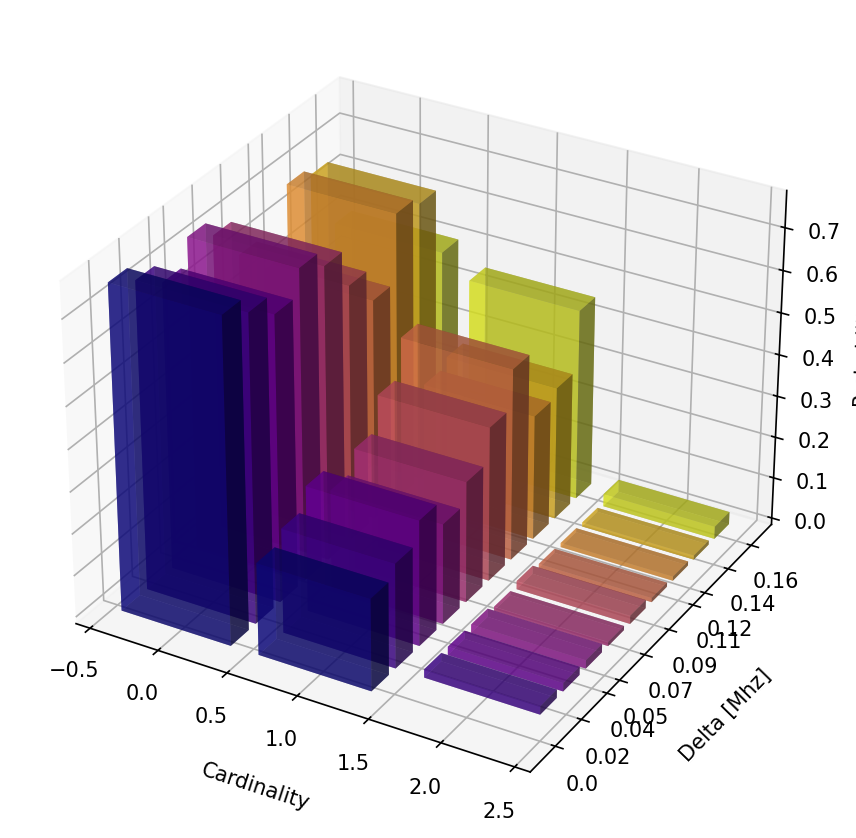

In [26]:
independent_set_probabilities("grid4x4 sqrt2 erf sweep")
plot_set_probabilites("grid4x4 sqrt2 erf sweep")

In [ ]:
peform_sweep(unit_disc_grid_3_1, 6, "grid 3")

In [ ]:
durations = [0.2,1.6,0.2]


def piecewise_approximate(start_val, end_val, start_t, end_t, func):
    
    
